In [1]:
import os
from PIL import Image
import numpy as np

In [6]:
def get_average_image_size(dataset_path):
    widths, heights = [], []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                try:
                    img_path = os.path.join(class_path, img_name)
                    with Image.open(img_path) as img:
                        w, h = img.size
                        widths.append(w)
                        heights.append(h)
                except:
                    continue
    avg_width = int(np.mean(widths))
    avg_height = int(np.mean(heights))
    return avg_width, avg_height

def load_caltech20_dataset(dataset_path, resize=False):
    avg_w, avg_h = get_average_image_size(dataset_path)
    data, labels = [], []
    classes = sorted(os.listdir(dataset_path))

    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = Image.open(img_path).convert("RGB")
                    if resize:
                        img = img.resize((avg_w, avg_h))
                    data.append(np.array(img))
                    labels.append(label)
                except:
                    print(f"Erreur avec {img_path}")

    return np.array(data), np.array(labels), classes

In [7]:
X, y, class_names = load_caltech20_dataset("caltech20", resize=True)
print(X.shape, y.shape)


(1051, 252, 277, 3) (1051,)


In [8]:
print(f"Nombre d'images : {len(X)}")
print(f"Nombre de classes : {len(class_names)}")
print(f"Exemples de classes : {class_names[:5]}")

Nombre d'images : 1051
Nombre de classes : 20
Exemples de classes : ['ant', 'beaver', 'brontosaurus', 'cannon', 'chair']


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 840
Testing set size: 211


pip install opencv-contrib-python scikit-learn
pip install opencv-python

In [12]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def extract_sift_features_from_images(images):
    sift = cv2.SIFT_create()
    all_descriptors = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            all_descriptors.append(descriptors)
    return all_descriptors

def sample_descriptors(descriptor_list, max_samples=10000):
    all_desc = np.vstack(descriptor_list)
    idx = np.random.choice(len(all_desc), min(max_samples, len(all_desc)), replace=False)
    return all_desc[idx]

def reduce_dimensionality(descriptors, n_components=64):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(descriptors), pca

def build_codebook(descriptors, k=100):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(descriptors)
    return kmeans

def compute_bow_histogram(img, sift, pca, kmeans):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return np.zeros(kmeans.n_clusters)
    descriptors = pca.transform(descriptors)
    labels = kmeans.predict(descriptors)
    hist, _ = np.histogram(labels, bins=np.arange(kmeans.n_clusters + 1))
    return hist / np.linalg.norm(hist)

def encode_bow_features(images, sift, pca, kmeans):
    return np.array([compute_bow_histogram(img, sift, pca, kmeans) for img in images])


In [14]:
sift = cv2.SIFT_create()
descs = extract_sift_features_from_images(X_train)
sampled = sample_descriptors(descs)
reduced, pca = reduce_dimensionality(sampled)
kmeans = build_codebook(reduced)

X_train_bow = encode_bow_features(X_train, sift, pca, kmeans)
X_test_bow = encode_bow_features(X_train, sift, pca, kmeans)



In [16]:
import matplotlib.pyplot as plt

def plot_bow_histogram(hist, class_name=None):
    plt.figure(figsize=(8, 4))
    plt.bar(np.arange(len(hist)), hist)
    plt.title(f'BoW Histogram {f"({class_name})" if class_name else ""}')
    plt.xlabel('Visual Word Index')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def show_sift_keypoints(img):
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    keypoints = sift.detect(gray, None)
    img_kp = cv2.drawKeypoints(img, keypoints, None,
                               flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_kp)
    plt.axis('off')
    plt.title("SIFT Keypoints")
    plt.show()


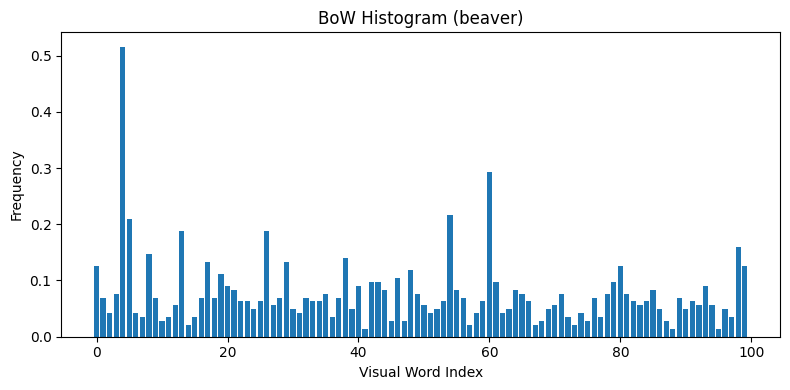

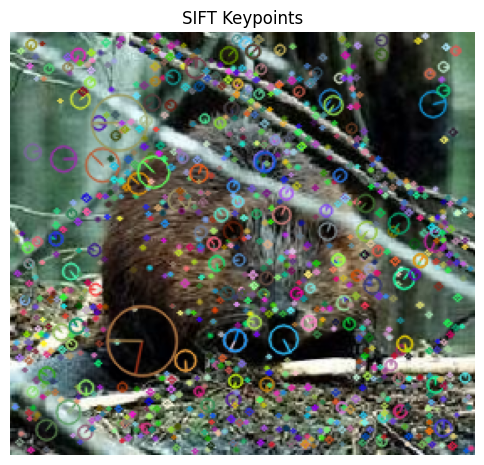

In [20]:
# Histogramme BoW
hist = X_train_bow[19]
plot_bow_histogram(hist, class_name=class_names[y_train[19]])

# Visualiser les SIFT
show_sift_keypoints(X_train[19])
